<a href="https://colab.research.google.com/github/RostislavKorst/GANs-MIPT-2022-Masters/blob/main/Assignment%204/04_tricks_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**ITMO University, Autumn 2022, MSc course**


## Assignment 4

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

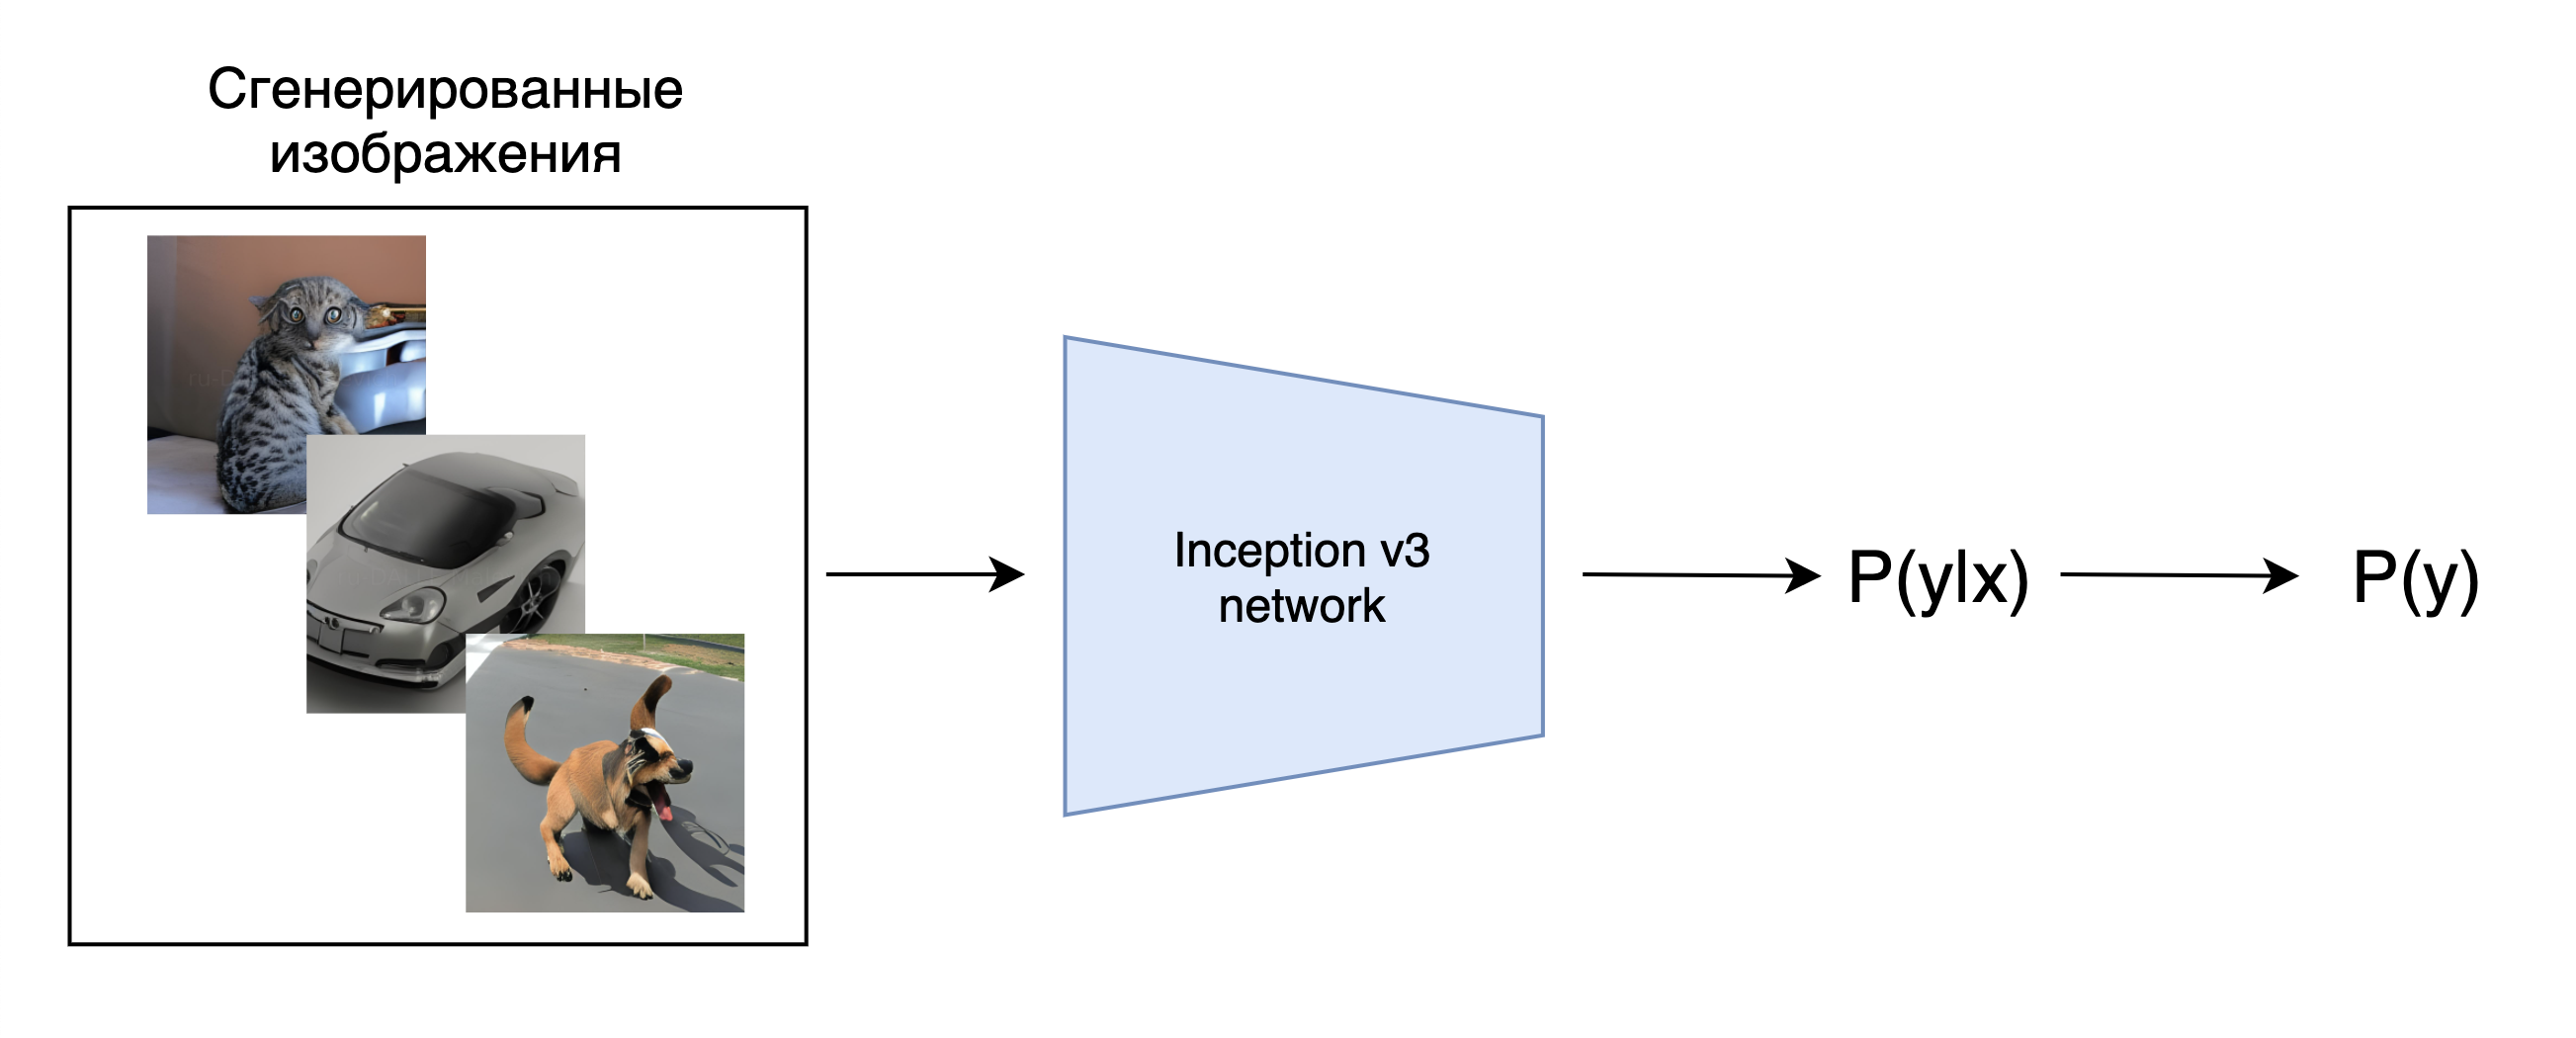

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i 
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx 
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

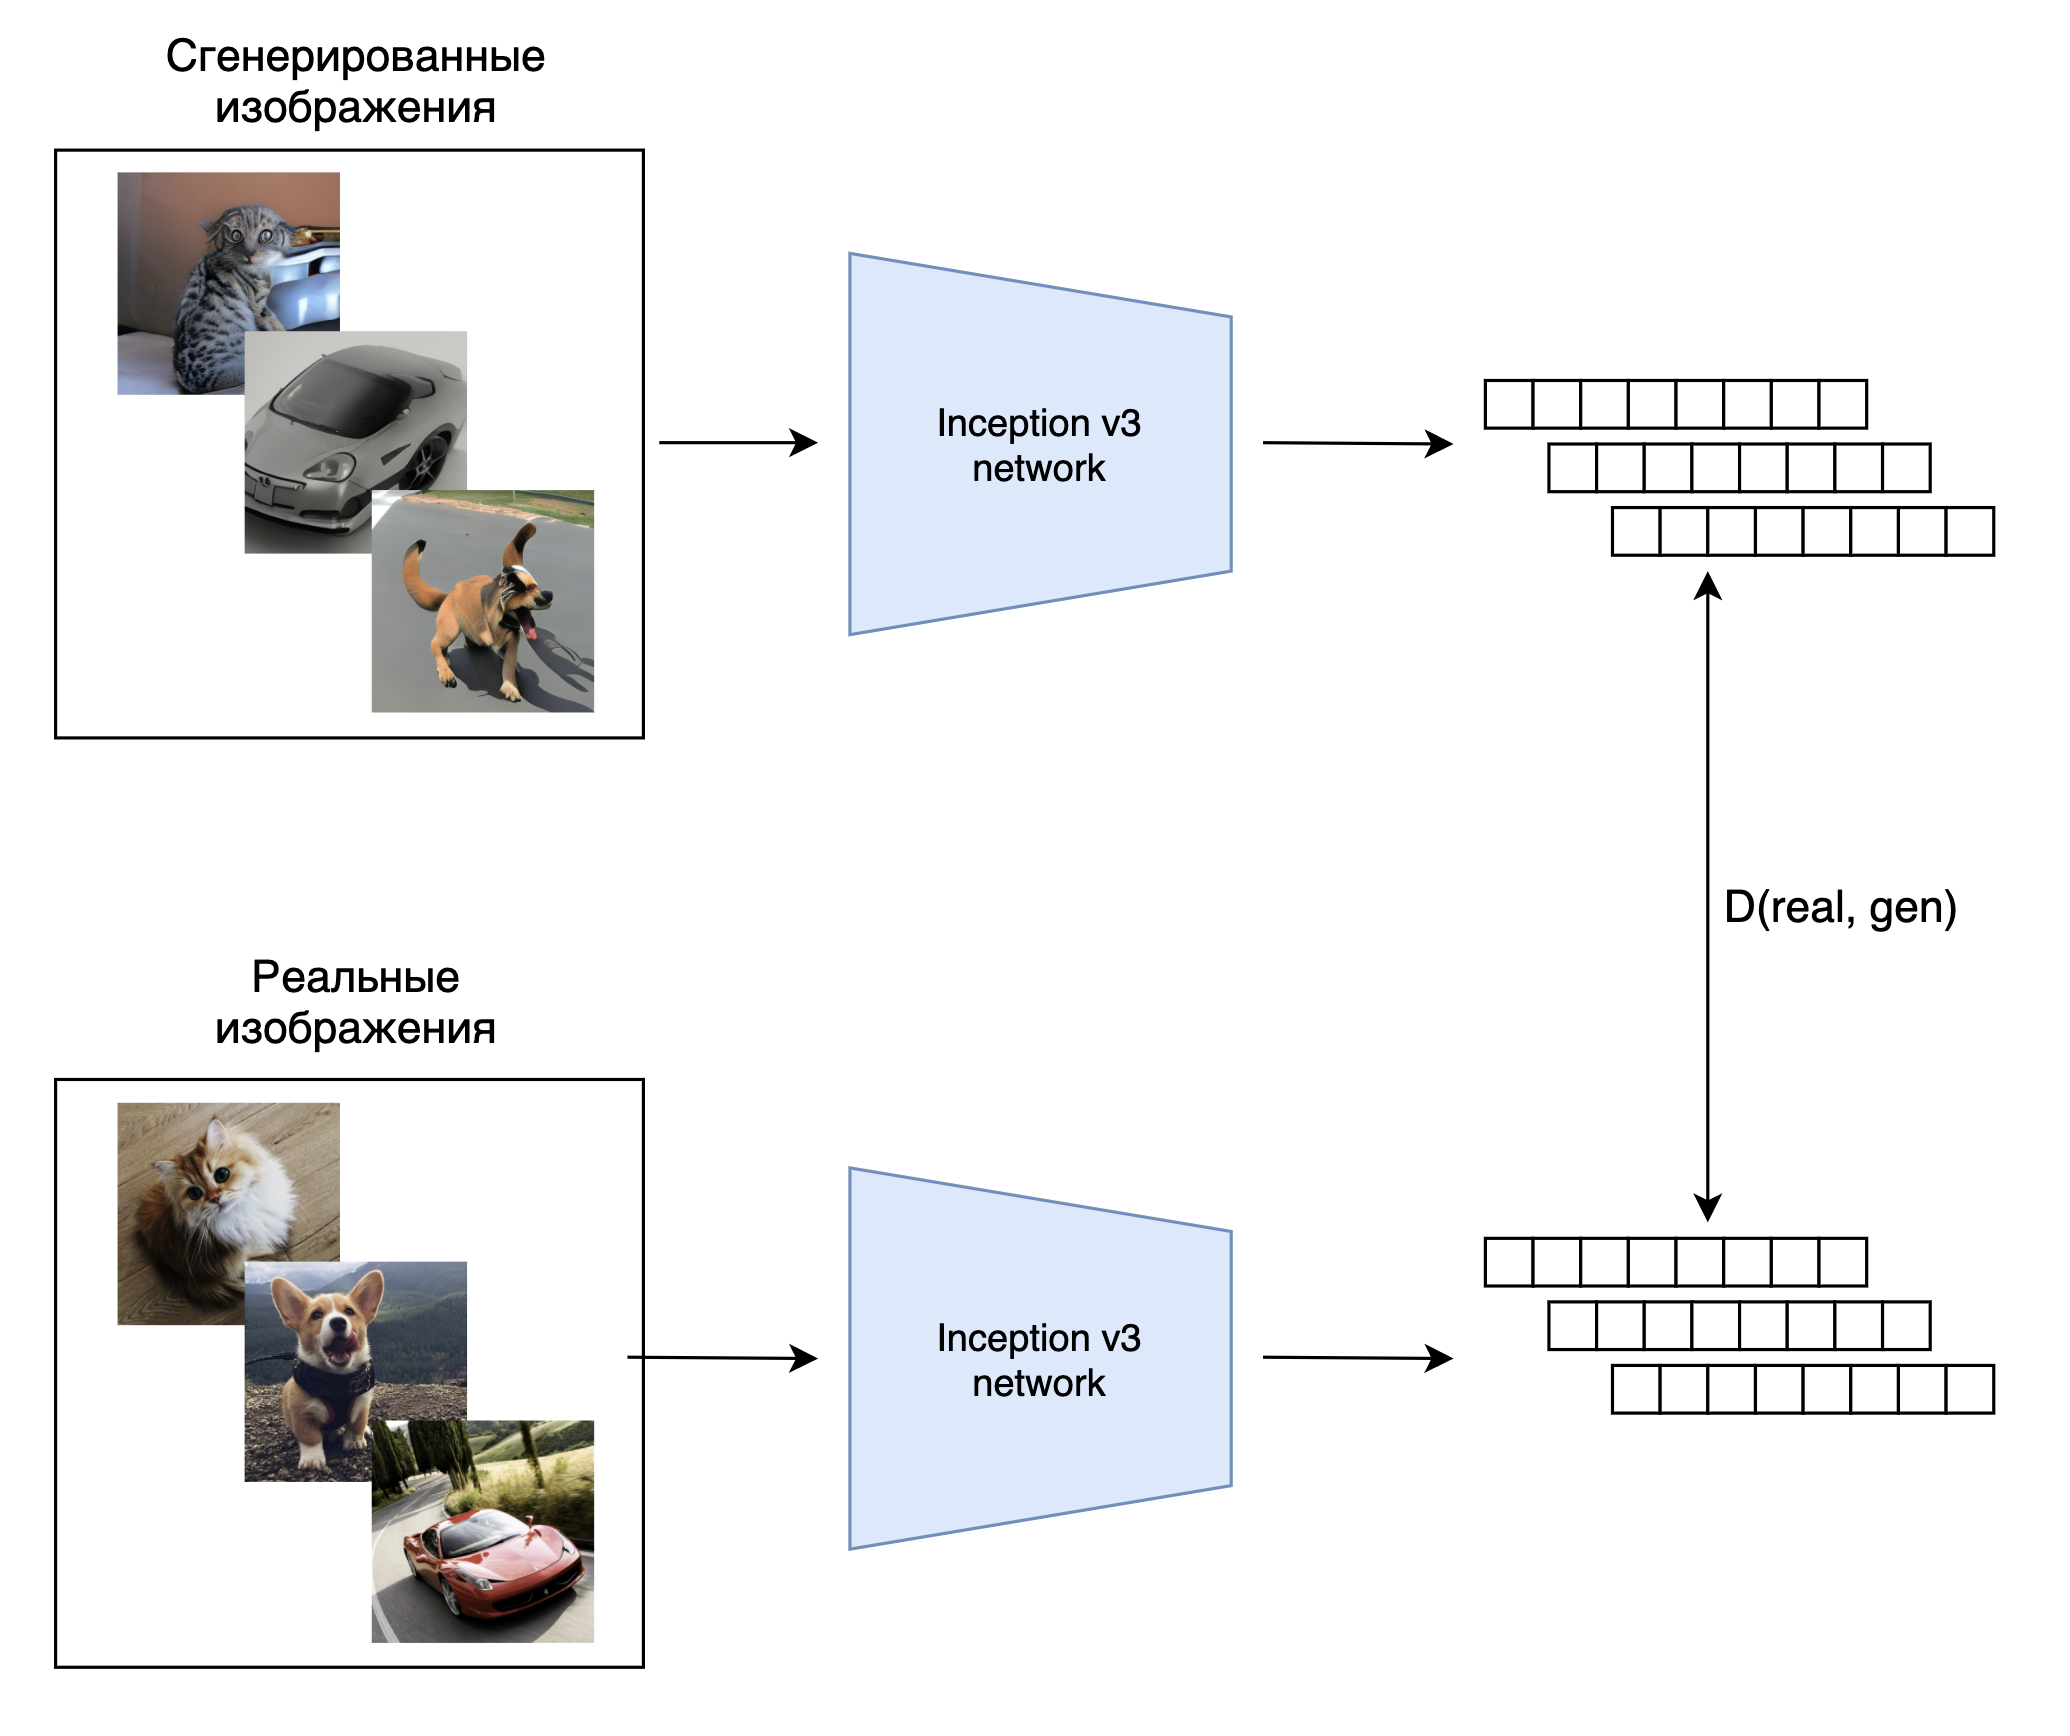

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета. 


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет 

* Обучить GAN на датасете CIFAR10, используя методы регуляризации: label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей без регуляризаций и с различными их комбинациями (хотя бы одной). Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
DCGAN | | 
Label Smoothing (LS) |  | 
Spectral Normalization (SN) |  | 
DCGAN + LS + SN | | 
CIFAR10 | 10.98 ± 0.22 | 3.1508


### Define parameters & Load Dataset 

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn as nn
from PIL import Image 
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
#from torchsummary import summary
from datetime import datetime
import os
%matplotlib inline 
plt.style.use("ggplot")

class CFG:
    batch_size = 64
    latent_size = 64
    num_epochs = 20
    workers = 4
    seed = 2021
    image_W = 64
    image_H = 64
    image_C = 3 ## number chanels  ngf = 64 #Size of feature maps in generator
    download = True
    dataroot = "data"
    nz = 100 #latent random input vector
    ngf = 64 #Size of feature maps in generator
    ndf = 64 #Size of feature maps in discriminator
    dlr = 0.0001
    glr = 0.0002
    lrelu_slope = 0.02
    device = 'cuda'  
    sample_dir = "./images_v2/"
    
if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)
cifar_dataset = torchvision.datasets.CIFAR10(root=CFG.dataroot, download=CFG.download,
                               transform=transforms.Compose([
                                  transforms.Resize([CFG.image_H, CFG.image_W]),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))


Extracting data\cifar-10-python.tar.gz to data


Label:  6


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.99215686, -0.860915  , -0.7296732 , -0.59843135, -0.46718955,
        -0.33594772, -0.20470588, -0.07346405,  0.05777778,  0.1890196 ,
         0.32026145,  0.45150328,  0.5827451 ,  0.71398693,  0.84522873,
         0.9764706 ], dtype=float32),
 <a list of 12288 BarContainer objects>)

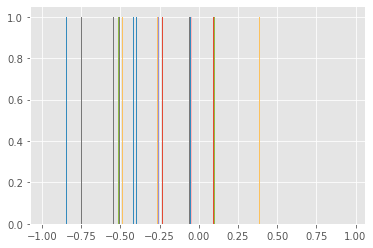

In [2]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

In [3]:
# unnormalization image from range (-1)-1 to range 0-1 to display it
def denorm(img):
    out = (img + 1) / 2
    return out.clamp(0, 1)

# show  image sample with matplotlib

In [4]:
data_loader = DataLoader(cifar_dataset, batch_size=CFG.batch_size, shuffle=True, drop_last=True)

In [5]:
len(data_loader)

781

In [7]:
img, label = cifar_dataset[0]
img = denorm(img.unsqueeze(0)).squeeze(0) # The functions expects first dim to be batch_size
print("Min: ", img.min().item())
print("Max: ", img.max().item())

Min:  0.003921568393707275
Max:  0.9882352948188782


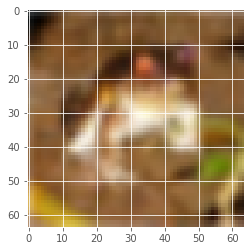

In [8]:
# show image sample with matplotlib
def plot_torch_image(img, **kwargs):
    '''
    Input image is a torch tensor with the following dims (C,H,W)
    To plot it with matplotlib, we need to change it to (H,W,C) 
    kwargs varaible is used to pass other parameters to 'imshow' function.
    '''
    plt.imshow(img.permute(1, 2, 0) , **kwargs)
    
plot_torch_image(img)


# Спектральная нормализация

In [9]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks 
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [10]:
import torch.nn as nn
import torch.nn.functional as F
class Generator(nn.Module):
    def __init__(self, nc, h, w, nz, ngf):
        #ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu 
        #ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        
        # ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding 
        super(Generator, self).__init__()
        self.nc = nc
        self.h = h
        self.w = w
        self.ngf = ngf
        
        self.linear = nn.Linear(nz, nc * h * w)
        self.conv1 = nn.ConvTranspose2d(in_channels=nc, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch1 = nn.BatchNorm2d(ngf)
        self.conv2 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch2 = nn.BatchNorm2d(ngf)
        self.conv3 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch3 = nn.BatchNorm2d(ngf)
        self.conv4 = nn.ConvTranspose2d(in_channels=ngf, out_channels=ngf, kernel_size=(3,3), stride=1, padding=1)
        self.batch4 = nn.BatchNorm2d(ngf) 
        self.conv5 = nn.ConvTranspose2d(in_channels=ngf, out_channels=nc, kernel_size=(3,3), stride=1, padding=1)
        # init weights
        self.linear.weight.data.normal_(0.0, 0.02) 
        self.conv1.weight.data.normal_(0.0, 0.02)
        self.conv2.weight.data.normal_(0.0, 0.02)
        self.conv3.weight.data.normal_(0.0, 0.02)
        self.conv4.weight.data.normal_(0.0, 0.02)
        self.conv5.weight.data.normal_(0.0, 0.02)
    def forward(self, x):
        bs= x.shape[0]
        x = self.linear(x)
        x = x.view(bs, self.nc, self.h, self.w)
        x = self.conv1(x)
        x = self.batch1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = nn.ReLU()(x)     
        x = self.conv3(x)
        x = self.batch3(x)
        x = nn.ReLU()(x) 
        x = self.conv4(x)
        x = self.batch4(x)
        x = nn.ReLU()(x)
        x = self.conv5(x)
        return torch.tanh(x)


# Discriminator 

class Discriminator(nn.Module):
    def __init__(self, nc, h, w, ndf):
    #conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(Discriminator, self).__init__()
        self.conv1 = SpectralNorm(nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1))
        self.l_relu1 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv2 = SpectralNorm(nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1))
        self.bn1 = nn.BatchNorm2d(ndf)
        self.l_relu2 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv3 = SpectralNorm(nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1))
        self.bn2 = nn.BatchNorm2d(ndf)
        self.l_relu3 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv4 = SpectralNorm(nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1))
        self.bn3 = nn.BatchNorm2d(ndf)
        self.l_relu4 = nn.LeakyReLU(CFG.lrelu_slope)
        self.conv5 = SpectralNorm(nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=(3,3), stride=1, padding=1))
        
        self.linear = nn.Linear(262144, 1)
        # init weights
        #self.conv1.weight.data.normal_(0.0, 0.02)
        #self.conv2.weight.data.normal_(0.0, 0.02)
        #self.conv3.weight.data.normal_(0.0, 0.02)
        #self.conv4.weight.data.normal_(0.0, 0.02)
        #self.conv5.weight.data.normal_(0.0, 0.02)
        #self.linear.weight.data.normal_(0.0, 0.02)
    def forward(self, x):
        x = self.conv1(x)
        x = self.l_relu1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.l_relu2(x)
        x = self.conv3(x)
        x = self.bn2(x) 
        x = self.l_relu3(x)
        x = self.conv4(x)
        x = self.bn3(x) 
        x = self.l_relu4(x)
        x = self.conv5(x)
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return nn.Sigmoid()(x)

In [11]:
# create new Generator model
G = Generator(CFG.image_C, CFG.image_H, CFG.image_W, CFG.nz, CFG.ngf)
# create new Discriminator model
D = Discriminator(CFG.image_C, CFG.image_H, CFG.image_W, CFG.ndf)

In [12]:
# show the output of model
y = G(torch.randn(2, CFG.nz))

In [13]:
# define the criterion is nn.BCELoss()
loss_fn = nn.BCELoss()
## Define the optimizer for generator and discrimator
G_optim = torch.optim.Adam(G.parameters(),betas=(0.5, 0.999),  lr=CFG.glr)
D_optim = torch.optim.Adam(D.parameters(),betas=(0.5, 0.999),  lr=CFG.dlr)

In [16]:
# feel free to reuse your training functions

Discriminator Training

In [17]:
# Label Smoothing, i.e. if you have two target labels: Real=1 and Fake=0, then for each incoming sample,
#  if it is real, then replace the label with a random number between 0.7 and 1.2, and 
#  if it is a fake sample, replace it with 0.0 and 0.3 (for example).
#make the labels the noisy for the discriminator: occasionally flip the labels when training the discriminator

In [14]:

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()
    ## reset gradient for optimizer of generator and discrimator
  

LABEL_SMOOTH = 0.95
def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = (torch.ones(CFG.batch_size, 1) * LABEL_SMOOTH).to(CFG.device)
    fake_labels = (torch.zeros(CFG.batch_size, 1) + (1 - LABEL_SMOOTH)).to(CFG.device)
    
    outputs = D(images)
    # Loss for real images
    loss_r = loss_fn(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(CFG.batch_size, CFG.nz).to(CFG.device)
    fake_images = G(z)
    outputs = D(fake_images)
    loss_f = loss_fn(outputs, fake_labels)
    fake_score = outputs
    # Sum losses
    d_loss = loss_r + loss_f
    # Adjust the parameters using backprop
    d_loss.backward()
    # Compute gradients
    D_optim.step()
    # Reset gradients
    reset_grad()

    return d_loss, real_score, fake_score


Generator Training

In [19]:
#Add gauss noise
#noise = 0.005*np.random.uniform()*np.amax(sound)

In [15]:
def train_generator():
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz))).to(CFG.device)
    fake_images = G(z)
    labels = (torch.ones(CFG.batch_size, 1) * 0.9).to(CFG.device)
    # calculate the generator loss
    outputs = D(fake_images)
    g_loss = loss_fn(outputs, labels)
    # Backprop and optimize
    g_loss.backward()
    G_optim.step()
    # Reset gradients
    reset_grad()
    return g_loss, fake_images

## Start the training process

In [16]:
def save_fake_images(index):
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (CFG.batch_size, CFG.nz))).to(CFG.device)
    fake_images = G(sample_vectors)
#     fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=8)

In [17]:
%%time
print(f"[{datetime.now()}] -- Training started")
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(CFG.device)
D.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
#         images = images.reshape(CFG.batch_size, -1).to(CFG.device)
        images = images.to(CFG.device)
        # Train the generator n times
        n = 3
        for _ in range(n):
            g_loss, fake_images = train_generator()
        # Train the discriminator  once
        d_loss, real_score, fake_score = train_discriminator(images)
        # Inspect the losses
        if (i+1) % 100 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('[{}] -- Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(datetime.now(), epoch+1, CFG.num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    # Sample and save images
    save_fake_images(epoch+1)
        

[2022-12-21 19:42:06.898166] -- Training started
[2022-12-21 19:45:35.379437] -- Epoch [1/20], Step [100/781], d_loss: 2.9922, g_loss: 2.9247, D(x): 0.10, D(G(z)): 0.08
[2022-12-21 19:48:07.398504] -- Epoch [1/20], Step [200/781], d_loss: 1.0345, g_loss: 1.1065, D(x): 0.65, D(G(z)): 0.36
[2022-12-21 19:50:39.387068] -- Epoch [1/20], Step [300/781], d_loss: 0.9747, g_loss: 1.0735, D(x): 0.67, D(G(z)): 0.34
[2022-12-21 19:53:11.663718] -- Epoch [1/20], Step [400/781], d_loss: 1.6765, g_loss: 2.0048, D(x): 0.33, D(G(z)): 0.19
[2022-12-21 19:55:44.004834] -- Epoch [1/20], Step [500/781], d_loss: 1.1932, g_loss: 0.8081, D(x): 0.75, D(G(z)): 0.52
[2022-12-21 19:58:16.305553] -- Epoch [1/20], Step [600/781], d_loss: 1.1414, g_loss: 0.9614, D(x): 0.62, D(G(z)): 0.39
[2022-12-21 20:00:48.634575] -- Epoch [1/20], Step [700/781], d_loss: 1.2865, g_loss: 0.7947, D(x): 0.75, D(G(z)): 0.57
Saving fake_images-0001.png
[2022-12-21 20:05:25.046021] -- Epoch [2/20], Step [100/781], d_loss: 1.1578, g_los

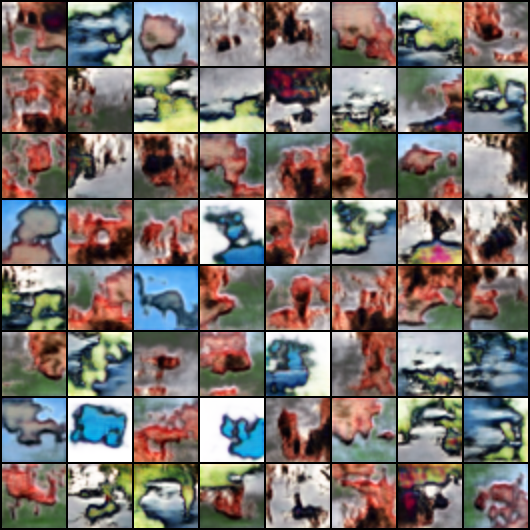

In [19]:
from IPython.display import Image
Image(os.path.join(CFG.sample_dir, 'fake_images-0020.png'))

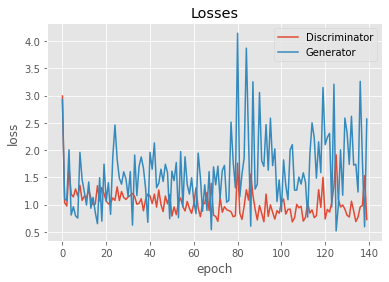

In [22]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

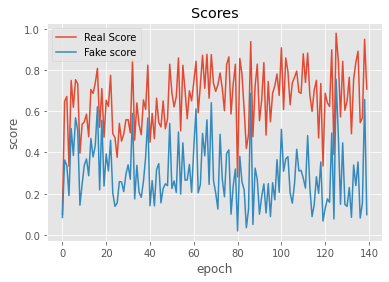

In [23]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

### install library from https://github.com/w86763777/pytorch-gan-metrics.git
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [1]:
# clone is repo: https://github.com/w86763777/pytorch-gan-metrics.git and install pytorch-gan-metrics
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...


You should consider upgrading via the 'D:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [24]:
%cd pytorch-gan-metrics
#### Prepare Statistics for FID


C:\Users\810681\Documents\Python\ITMO\3-semestr\ForLabs\Lab4\pytorch-gan-metrics


In [25]:
 # import function from pytorch_gan_metrics 
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid)

# create the Generator Dataset. returns the image, generated from the Generator network
class GeneratorDataset(Dataset):
    def __init__(self, G, z_dim):
        self.G = G
        self.z_dim = z_dim
    
    def __len__(self):
        return 500
    
    def __getitem__(self, index):
        return self.G(torch.randn(1, self.z_dim).cuda())[0]

# define dataset
#create dataloader

# Inception Score
# Frechet Inception Distance
# Inception Score + Frechet Inception Distance


In [26]:
g_set = GeneratorDataset(G, 100)
g_loader = DataLoader(g_set, batch_size=100, shuffle=True, drop_last=False)

In [1]:
# Inception Score
IS, IS_std = get_inception_score(g_loader)
print(f"Inception Score: {IS} (std: {IS_std})")
# Frechet Inception Distance
FID = get_fid(g_loader, 'C://Users//810681//Documents//Python//ITMO//3-semestr//ForLabs//Lab4//statistics//cifar10.npz')
print(f"FID socre: {FID}")

Inception Score: 3.2145412284649 (std: 0.13608103962312186)
FID socre: 233.157241222072
